# Data analysis for OpenRank leaderboard.

This notebook is used to generate the figures for the paper - Motivating Open Source Collaborations Through Social Network Evaluation: A Gamification Practice from Alibaba.

## Data source

- All the project metrics except `reactions` are retrieved from [OpenDigger](https://github.com/X-lab2017/open-digger) which is an open source project to provide open source project analysis data.
- The `reactions` metric is retrieved by [GitHub restful API](https://docs.github.com/en/rest/reactions).
- Control data which is collaborative events from [all Chinese companies](https://github.com/X-lab2017/open-digger/blob/master/labeled_data/regions/CN.yml) are also from [OpenDigger](https://github.com/X-lab2017/open-digger).
- For privacy concern, we remove the corresponding project name and developer GitHub login in survey result data, so the survey result data can not be used to generate the OpenRank weighted average score of the survey.

## Visulization

All the figures generated by this notebook are directly used in the paper without any more modificatiion.

In [1]:
pip install numpy pandas matplotlib statsmodels tabulate scipy -q --disable-pip-version-check --no-warn-script-location

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from tabulate import tabulate

import json
import csv
import warnings
warnings.filterwarnings('ignore')

In [2]:
projs = ['ice', 'spring-cloud-alibaba', 'DataX', 'easyexcel', 'seata', 'openyurt', 'fluid']
metrics = ['issues_new', 'issue_comments',
           'change_requests_new', 'change_requests_accepted', 'change_requests_reviews',
           'reaction_count',
           'new_contributors', 'participants'
          ]
# data is all the data will metric and proj name as index
data = {}
file = open('./data/control_data.json', mode='r')
# control data is used as a control in rdd
control_data = list(json.loads(file.read()).values())
for metric in metrics:
    data[metric] = [0] * 12
    for proj in projs:
        with open('./data/{}/{}.json'.format(proj, metric), mode='r') as file:
            for idx, x in enumerate(json.loads(file.read()).values()):
                data[metric][idx] += x

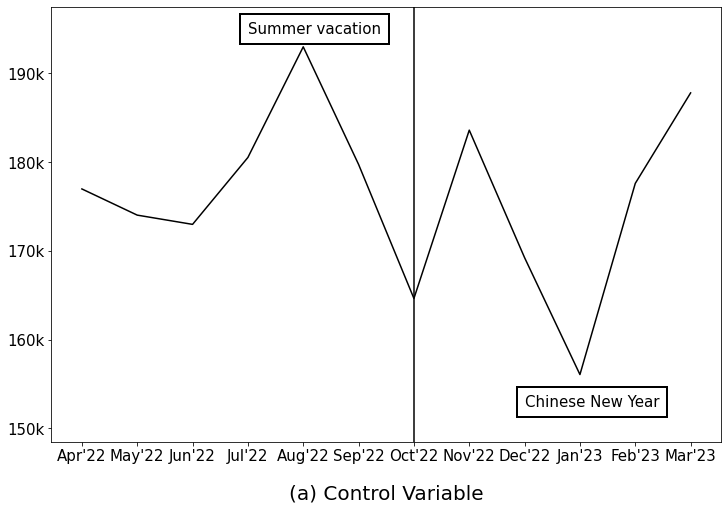

In [3]:
x = np.array(range(1, 13))
xLabels=np.array(["Apr'22","May'22","Jun'22","Jul'22","Aug'22","Sep'22","Oct'22","Nov'22","Dec'22","Jan'23","Feb'23","Mar'23"])
threshold = 7

G = np.where(x >= threshold, 1, 0)
A = np.where(x > threshold, x - threshold, 0)

# Show controle data
fig, ax = plt.subplots(figsize=(12, 8))
fig.set_facecolor('white')
plt.plot(x, list(map(lambda x: x / 1000, control_data)), color='black')
plt.xlabel('(a) Control Variable', fontsize=20, labelpad=20)
plt.xticks(ticks=x, labels=xLabels, fontsize=15)
plt.yticks(fontsize=15)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:0.0f}k'.format(x) for x in current_values])
plt.axvline(x=threshold, color='black')
ax.annotate('Summer vacation', xy=(4, 229), xytext=(4, 229), fontsize=15, bbox=dict(boxstyle="square,pad=0.5", fc="white", lw=2))
ax.annotate('Chinese New Year', xy=(9, 145), xytext=(9, 145), fontsize=15, bbox=dict(boxstyle="square,pad=0.5", fc="white", lw=2))
ax.set_ylim(137, 235)
plt.savefig("control_data.png")
plt.show()

def getEst(alpha, beta, gamma, delta, control, x):
    return alpha + beta * x + gamma * G[x] + delta * A[x] + control * control_data[x]

def show(alpha, beta, gamma, delta, control, data, ytitle):
    fig = plt.figure(figsize=(12, 8))
    fig.set_facecolor('white')
    plt.scatter(x, data, facecolors='none', edgecolors='black')
    for m in range(1, 12):
        plt.plot([m, m + 1], [getEst(alpha, beta, gamma, delta, control, m - 1), getEst(alpha, beta, gamma, delta, control, m) ], color = 'black')
    plt.xlabel('Time', fontsize=20, labelpad=20)
    plt.xticks(ticks=x, labels=xLabels, fontsize=15)
    plt.yticks(fontsize=15)
    plt.axvline(x=threshold, color='black')
    if ytitle == "change_requests_new":
        plt.xlabel('(b) Change Requests New', fontsize=20, labelpad=20)
        plt.savefig("{}_rdd.png".format(ytitle))
    if ytitle == "issue_comments":
        plt.xlabel('(c) Issue Comments', fontsize=20, labelpad=20)
        plt.savefig("{}_rdd.png".format(ytitle))
    if ytitle == "reaction_count":
        plt.xlabel('(d) Reactions', fontsize=20, labelpad=20)
        plt.savefig("{}_rdd.png".format(ytitle))
    plt.show()

def analysis(data, metric, ytitle):
    rdd_data = pd.DataFrame({
        'T': x,
        'Y': data,
        'G': G,
        'A': A,
        'C': control_data
    })
    formula = 'Y ~ T + G + A + C'
    model = smf.ols(formula, data=rdd_data)
    res = model.fit()
    print('Analysis result for metric {}'.format(metric))
    print(res.summary())
    params = res._results.params
    (alpha, beta, gamma, delta, control) = tuple(params)
    show(alpha, beta, gamma, delta, control, data, ytitle)
    old_val = 0
    new_val = 0
    for i in range(0, 6):
        old_val += data[i]
        new_val += data[i + 6]
    print('Average improvement is {}'.format((new_val/old_val - 1) * 100))

Analysis result for metric issues_new
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     8.704
Date:                Wed, 17 May 2023   Prob (F-statistic):            0.00751
Time:                        07:29:36   Log-Likelihood:                -51.147
No. Observations:                  12   AIC:                             112.3
Df Residuals:                       7   BIC:                             114.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -1

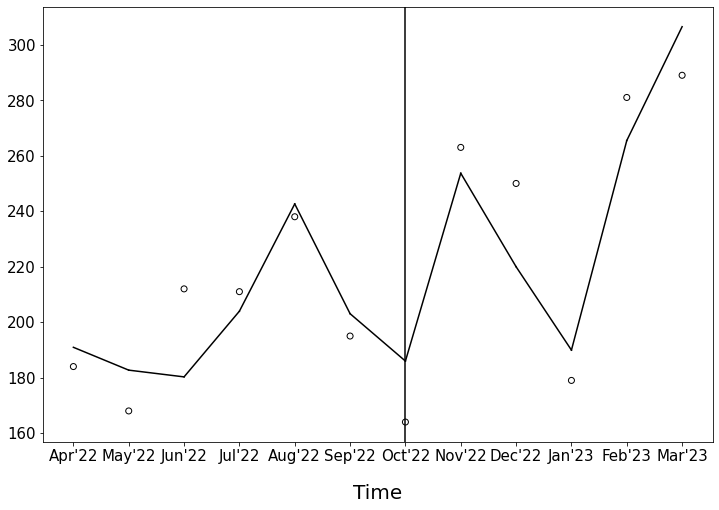

Average improvement is 18.04635761589404
Analysis result for metric issue_comments
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     68.53
Date:                Wed, 17 May 2023   Prob (F-statistic):           1.07e-05
Time:                        07:29:36   Log-Likelihood:                -67.506
No. Observations:                  12   AIC:                             145.0
Df Residuals:                       7   BIC:                             147.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

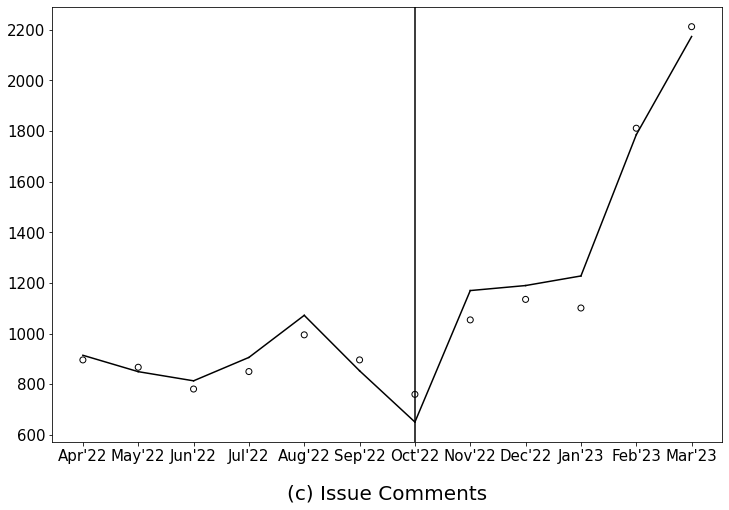

Average improvement is 52.75307473982971
Analysis result for metric change_requests_new
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     8.254
Date:                Wed, 17 May 2023   Prob (F-statistic):            0.00870
Time:                        07:29:36   Log-Likelihood:                -57.174
No. Observations:                  12   AIC:                             124.3
Df Residuals:                       7   BIC:                             126.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

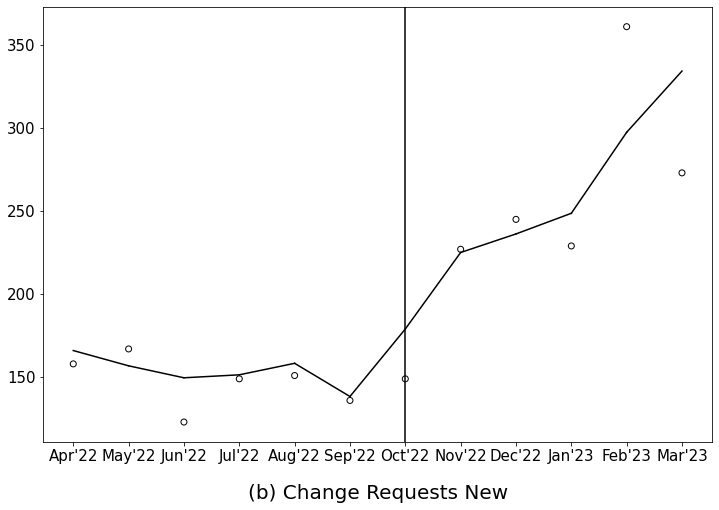

Average improvement is 67.87330316742081
Analysis result for metric change_requests_accepted
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     8.347
Date:                Wed, 17 May 2023   Prob (F-statistic):            0.00844
Time:                        07:29:36   Log-Likelihood:                -56.473
No. Observations:                  12   AIC:                             122.9
Df Residuals:                       7   BIC:                             125.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

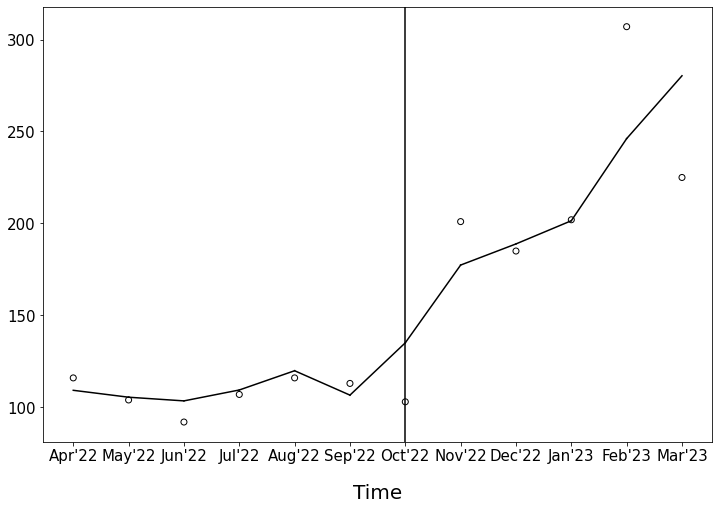

Average improvement is 88.73456790123457
Analysis result for metric change_requests_reviews
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     11.95
Date:                Wed, 17 May 2023   Prob (F-statistic):            0.00302
Time:                        07:29:37   Log-Likelihood:                -58.655
No. Observations:                  12   AIC:                             127.3
Df Residuals:                       7   BIC:                             129.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

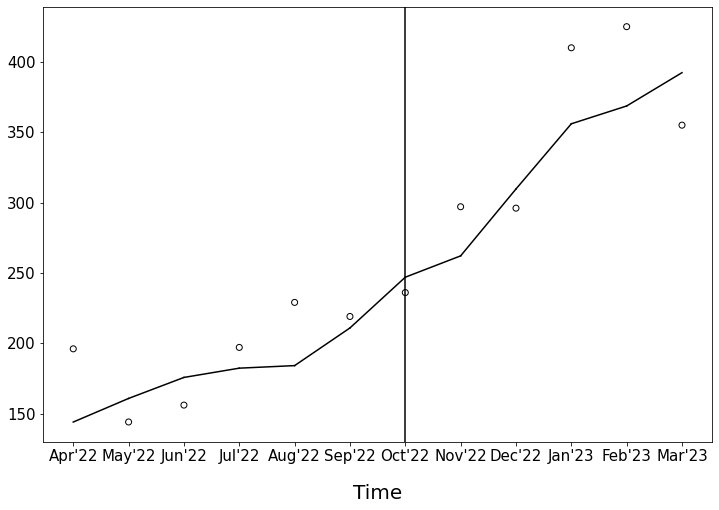

Average improvement is 76.95004382120946
Analysis result for metric reaction_count
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     16.57
Date:                Wed, 17 May 2023   Prob (F-statistic):            0.00112
Time:                        07:29:37   Log-Likelihood:                -28.685
No. Observations:                  12   AIC:                             67.37
Df Residuals:                       7   BIC:                             69.80
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

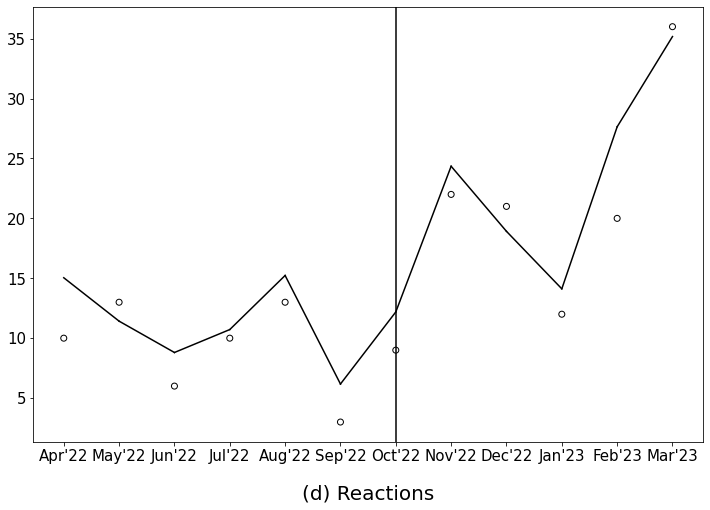

Average improvement is 118.18181818181816
Analysis result for metric new_contributors
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     3.443
Date:                Wed, 17 May 2023   Prob (F-statistic):             0.0738
Time:                        07:29:37   Log-Likelihood:                -40.871
No. Observations:                  12   AIC:                             91.74
Df Residuals:                       7   BIC:                             94.17
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

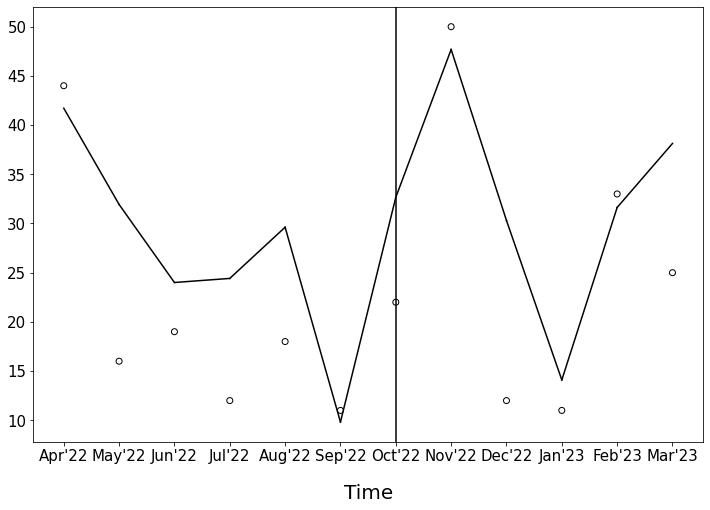

Average improvement is 27.499999999999993
Analysis result for metric participants
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     19.49
Date:                Wed, 17 May 2023   Prob (F-statistic):           0.000676
Time:                        07:29:37   Log-Likelihood:                -47.474
No. Observations:                  12   AIC:                             104.9
Df Residuals:                       7   BIC:                             107.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

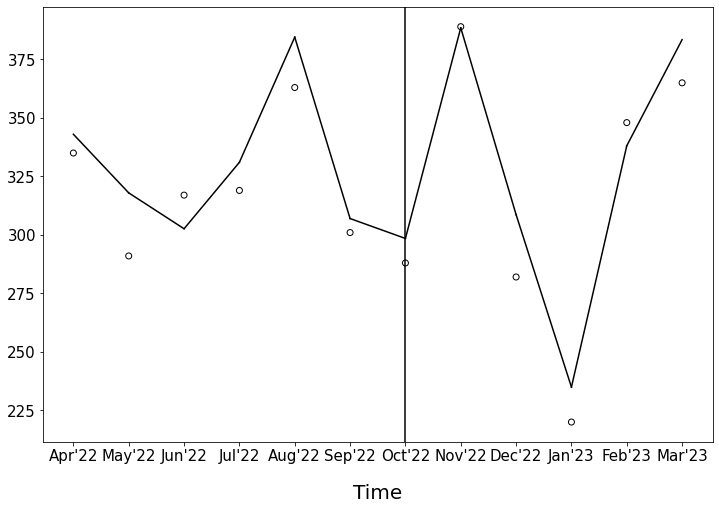

Average improvement is -1.7653167185877505


In [4]:
for metric in data:
    analysis(data[metric], metric, metric)

| Count type            |   Count |
|-----------------------+---------|
| Total count           |      63 |
| With role count       |      17 |
| No role above 4 count |      55 |
| Role above 4 count    |      17 |
| Role above 5 count    |      11 |
| Type         |   Score |
|--------------+---------|
| Without role | 4.23913 |
| With role    | 4.64706 |
| Total        | 4.34921 |


<Figure size 432x288 with 0 Axes>

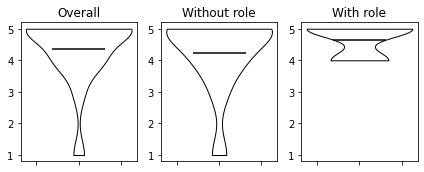

In [5]:
total_count = 0
role_count = 0
total_scores = []
role_scores = []
no_role_scores = []
above_4_count = 0
above_4_with_role = 0
above_5_with_role = 0

with open('./data/survey_result.csv', mode='r') as file:
    csv_file = csv.reader(file)
    for lines in csv_file:
        if len(lines) == 1:
            # skip first blank line
            continue
        else:
            score = int(lines[0])
            role = lines[1]
            total_count += 1
            total_scores.append(score)
            if (role != ''):
                role_count += 1
                role_scores.append(score)
                if score >= 4:
                    above_4_with_role += 1
                if score == 5:
                    above_5_with_role += 1
            else:
                no_role_scores.append(score)
            if score >= 4:
                above_4_count += 1

print(tabulate([['Total count', total_count],
                ['With role count', role_count],
                ['No role above 4 count', above_4_count],
                ['Role above 4 count', above_4_with_role],
                ['Role above 5 count', above_5_with_role]],
               headers=['Count type', 'Count'], tablefmt='orgtbl'))

def Average(lst):
    return sum(lst) / len(lst)

print(tabulate([['Without role', Average(no_role_scores)],
                ['With role', Average(role_scores)],
                ['Total', Average(total_scores)]],
               headers=['Type', 'Score'], tablefmt='orgtbl'))

plt.figure()
plt.style.use('grayscale')
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(6, 2.5))
fig.patch.set_facecolor('white')

def show(ax, data, name):
    violin = ax.violinplot([data], showmeans=True, showextrema=False, )
    ax.set_title(name)
    ax.set(ylim=(0.8,5.2))
    ax.set_xticklabels([])
    ax.set_facecolor('white')
    for pc in violin['bodies']:
        pc.set_facecolor('white')
        pc.set_edgecolor('black')
        pc.set_alpha(1)

show(ax1, total_scores, 'Overall')
show(ax2, no_role_scores, 'Without role')
show(ax3, role_scores, 'With role')

fig.tight_layout()
plt.savefig("survey_violin.png")
plt.show()